# Capstone Project - Harvardx Data Science



The Language Used for This Project: R

## Executive Summary

The dataset is originally from a database created in 1994, and it is available to download from Kaggle: https://www.kaggle.com/uciml/adult-census-income/. This project (the goal) is to answer an assumed business question - how can we predict an individual's annual income exceeds $50,000 or not - by using the given set of variables within the dataset?

The dataset contained the worldwide information that are included age, education, marital status, occupation, race, sex, native country, hours per week, capital gain/loss, etc. We will first download the dataset from the Kaggle site, and then we do some manipulation included data cleaning, wrangling and transformation. The next important step is data exploratory & analysis. In this step, we will explore and analyze the related variables from the dataset. We will also find the supportive evidences on how the dependent variables effect our target independent variable. Finally we will use appropriate machine learning algorithms to build our models, and the models will be evaluated. 

We will use root mean squared error (RMSE) to assess performance.


#### Load the appropriate packages that we will use in this project

In [ ]:
library(tidyverse)
library(caret)
library(matrixStats)
library(vcd)
library(scales)
library(ggthemes)
library(knitr)
library(ggplot2)
library(plyr)
library(gridExtra)
library(gmodels)
library(grid)
library(data.table)

#### Download and read the data

We will mark the missing value as "NA".

In [2]:
#############################################################
# Create edx set, validation set, and submission file
#############################################################


# if(!require(tidyverse)) install.packages("tidyverse", repos = "http://cran.us.r-project.org")
# if(!require(caret)) install.packages("caret", repos = "http://cran.us.r-project.org")

# MovieLens 10M dataset:
# https://grouplens.org/datasets/movielens/10m/
# http://files.grouplens.org/datasets/movielens/ml-10m.zip


temp <- tempfile()
download.file("https://www.kaggle.com/uciml/adult-census-income/downloads/adult-census-income.zip/3",temp, mode="wb")
unzip(temp, "adult.csv")

# mark the missing value as NA
incomeData <- read.table("adult.csv",
                       sep = ",", skip=0,
                       header = TRUE, 
                       na.strings = "?")
            

Warning message in unzip(temp, "adult.csv"):
"error 1 in extracting from zip file"

In [3]:
# dataset rows & columns
dim(incomeData)

[1] 32561    15

In [4]:
# for convenient, we rename some columns
setnames(incomeData, old=c("education.num","marital.status","capital.gain","capital.loss","hours.per.week","native.country"), new=c("education_num","marital_status","capital_gain","capital_loss","hours_per_week","native_country"))

In [5]:
# view the first 3-rows of the dataframe
incomeData[0:3,]

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
90,NA,77053,HS-grad,9,Widowed,NA,Not-in-family,White,Female,0,4356,40,United-States,<=50K
82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
66,NA,186061,Some-college,10,Widowed,NA,Unmarried,Black,Female,0,4356,40,United-States,<=50K


In [6]:
# the dataframe structure
str(incomeData, vec.len = 5, strict.width = "no", width = 30)

'data.frame':	32561 obs. of  15 variables:
 $ age           : int  90 82 66 54 41 34 38 74 68 41 45 38 ...
 $ workclass     : Factor w/ 8 levels "Federal-gov",..: NA 4 NA 4 4 4 4 7 1 4 4 6 ...
 $ fnlwgt        : int  77053 132870 186061 140359 264663 216864 150601 88638 422013 70037 172274 164526 ...
 $ education     : Factor w/ 16 levels "10th","11th",..: 12 12 16 6 16 12 1 11 12 16 11 15 ...
 $ education_num : int  9 9 10 4 10 9 6 16 9 10 16 15 ...
 $ marital_status: Factor w/ 7 levels "Divorced","Married-AF-spouse",..: 7 7 7 1 6 1 6 5 1 5 1 5 ...
 $ occupation    : Factor w/ 14 levels "Adm-clerical",..: NA 4 NA 7 10 8 1 10 10 3 10 10 ...
 $ relationship  : Factor w/ 6 levels "Husband","Not-in-family",..: 2 2 5 5 4 5 5 3 2 5 5 2 ...
 $ race          : Factor w/ 5 levels "Amer-Indian-Eskimo",..: 5 5 3 5 5 5 5 5 5 5 3 5 ...
 $ sex           : Factor w/ 2 levels "Female","Male": 1 1 1 1 1 1 2 1 1 2 1 2 ...
 $ capital_gain  : int  0 0 0 0 0 0 0 0 0 0 0 0 ...
 $ capital_loss  : int  4356 

Now we know the data types of each given variables

#### Data Cleaning & Wrangling 

In [7]:
# drop NA
incomeData <- na.omit(incomeData)

In [8]:
# re-enumerate the rows
row.names(incomeData) <- 1:nrow(incomeData)
print(dim(incomeData)[1])
incomeData[0:3,]

[1] 30162


age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


We take a look at variable "hours per week" and see what's the mean number

In [9]:
summary(incomeData$hours_per_week)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   40.00   40.00   40.93   45.00   99.00 

In order to find the correlation coefficient, we will add two columns: incomeN1 & incomeN2, but we'll drop them later

In [10]:
incomeData$incomeN1 <- incomeData$income
levels(incomeData$incomeN1) <- c(0,1)
incomeData$incomeN2 <- as.numeric(levels(incomeData$incomeN1))[incomeData$incomeN1]

In [11]:
cor(incomeData$hours_per_week, incomeData$incomeN2, method = "pearson")

[1] 0.2294801

We now know variable "hours_per_week" and "income" are correlated, so we transform the column into a new factor variable "dif_hours"

In [12]:
incomeData$dif_hours[incomeData$hours_per_week < 40] <- "less_than_40h"
incomeData$dif_hours[incomeData$hours_per_week >= 40 & incomeData$hours_per_week <= 45] <- "between_40h_and_45h"
incomeData$dif_hours[incomeData$hours_per_week > 45 & incomeData$hours_per_week <= 60  ] <- "between_45h_and_60h"
incomeData$dif_hours[incomeData$hours_per_week > 60 & incomeData$hours_per_week <= 80  ] <- "between_60h_and_80h"
incomeData$dif_hours[incomeData$hours_per_week > 80] <- "more_than_80h"

In [13]:
incomeData$dif_hours <- factor(incomeData$dif_hours, ordered = FALSE, 
                               levels = c("less_than_40h", "between_40h_and_45h","between_45h_and_60h",
                                      "between_60h_and_80h","more_than_80h"))

In [14]:
# summarize the derived factor variable
summary(incomeData$dif_hours)

less_than_40h between_40h_and_45h between_45h_and_60h between_60h_and_80h 
               6714               16606                5790                 857 
      more_than_80h 
                195

In [15]:
# percentages of each level
for(i in 1:length(summary(incomeData$dif_hours))){    
   print(round(100*summary(incomeData$dif_hours)[i]/sum(!is.na(incomeData$dif_hours)), 2)) }

less_than_40h 
        22.26 
between_40h_and_45h 
              55.06 
between_45h_and_60h 
               19.2 
between_60h_and_80h 
               2.84 
more_than_80h 
         0.65 


Now we simply repeat the pre-process onto other correlated variables

In [16]:
levels(incomeData$native_country)[36:41]

[1] "Taiwan"          "Thailand"        "Trinadad&Tobago" "United-States"  
[5] "Vietnam"         "Yugoslavia"

In [17]:
America <- c("Cuba", "Guatemala", "Jamaica", "Nicaragua", "Puerto-Rico",  "Dominican-Republic", "El-Salvador", 
                     "Haiti", "Honduras", "Mexico", "Trinadad&Tobago", "Ecuador", "Peru", "Columbia")
Asia <- c("Cambodia", "China", "Hong", "Laos", "Thailand", "Japan", "Taiwan", "Vietnam", "India", "Iran")
Europe <- c("England", "Germany", "Holand-Netherlands", "Ireland", 
                   "France", "Greece", "Italy", "Portugal", "Scotland", "Poland", "Yugoslavia", "Hungary")

In [18]:
incomeData <- mutate(incomeData, native_region = ifelse(native_country %in% Asia, "Asia",                                           
                                                 ifelse(native_country %in% America, "America",
                                                 ifelse(native_country %in% Europe, "Europe",
                                                 ifelse(native_country == "United-States", "United-States", 
                                                                          "Outlying-US" )))))

In [19]:
incomeData$native_region <- factor(incomeData$native_region, ordered = FALSE)
incomeData[0:3,]

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,incomeN1,incomeN2,dif_hours,native_region
82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,0,0,less_than_40h,United-States
54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,0,0,between_40h_and_45h,United-States
41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,0,0,between_40h_and_45h,United-States


And onto variable "capital_gain" & variable "capital_loss"

In [20]:
summary(incomeData$capital_gain)
summary(incomeData$capital_loss)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0    1092       0   99999 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   88.37    0.00 4356.00 

In [21]:
# the mean values on both variables
avg_gain <- mean(incomeData$capital_gain)
avg_loss <- mean(incomeData$capital_loss)
kable(data.frame(AVG_Capital_Gain = avg_gain, AVG_Capital_Loss = avg_loss), 
      caption = "Zero Values Included of AVG Capital")



| AVG_Capital_Gain| AVG_Capital_Loss|
|----------------:|----------------:|
|         1092.008|         88.37249|

In [22]:
# the mean without zero values
avg_gain <- mean(subset(incomeData$capital_gain, incomeData$capital_gain > 0))
avg_loss <- mean(subset(incomeData$capital_loss, incomeData$capital_loss > 0))
kable(data.frame(AVG_Capital_Gain = avg_gain, AVG_Capital_Loss = avg_loss), caption = "NonZero AVG Capital Values")



| AVG_Capital_Gain| AVG_Capital_Loss|
|----------------:|----------------:|
|          12977.6|         1867.898|

In [23]:
# We list the IQR of the nonzero values on both and use them as reference when derived new factor variables
interquartile_gain <- IQR(subset(incomeData$capital_gain, incomeData$capital_gain > 0))
interquartile_loss <- IQR(subset(incomeData$capital_loss, incomeData$capital_loss > 0))
gain_quartile <- quantile(x = subset(incomeData$capital_gain, incomeData$capital_gain > 0), probs = seq(0, 1, 0.25))
loss_quartile <- quantile(x = subset(incomeData$capital_loss, incomeData$capital_loss > 0), probs = seq(0, 1, 0.25))
kable(x = data.frame(Capital_Gain = gain_quartile, Capital_Loss = loss_quartile), caption = "Nonzero Capital Quartiles")



|     | Capital_Gain| Capital_Loss|
|:----|------------:|------------:|
|0%   |          114|          155|
|25%  |         3464|         1672|
|50%  |         7298|         1887|
|75%  |        14084|         1977|
|100% |        99999|         4356|

Now we know both "capital_gain" and "capital_loss" are highly correlated, so we reference the IQR values above, and then transform them into new factor variables "cap_gain" & "cap_loss"

In [24]:
income_dat <- mutate(incomeData,                      
                     cap_gain = ifelse(incomeData$capital_gain < 3600, " Low",
                                       ifelse(incomeData$capital_gain >= 3600 & 
                                              incomeData$capital_gain <= 15000, " Medium", " High")))
income_dat$cap_gain <- factor(income_dat$cap_gain,ordered = TRUE,levels = c(" Low", " Medium", " High"))

In [25]:
income_dat <- mutate(income_dat, 
                     cap_loss = ifelse(income_dat$capital_loss < 1500, " Low",
                                       ifelse(income_dat$capital_loss >= 1500 & 
                                              income_dat$capital_loss <= 2000, " Medium", " High")))
income_dat$cap_loss <- factor(income_dat$cap_loss,ordered = TRUE,levels = c(" Low", " Medium", " High"))

## Exploratory & Analysis Using the Data

 If we take a look of correlation coefficient, we can find some dependent variables are highly correlated to the independent variable "income". So we will explore and analyze those variables

In [26]:
# For example:
cor(income_dat$hours_per_week, income_dat$incomeN2, method = "pearson")
cor(income_dat$age, income_dat$incomeN2, method = "pearson")
cor(income_dat$fnlwgt, income_dat$incomeN2, method = "pearson")

[1] 0.2294801

[1] 0.2419981

[1] -0.008957423

We then box plot Nonzero Capital Gain and Nonzero Capital Loss through grouping by the income levels and find their mean values and median values (the "orange" dot denotes mean value and the black line inside the bos denotes median value). The visualizations make sense because people making more money lead to their bigger investment (gain/loss)

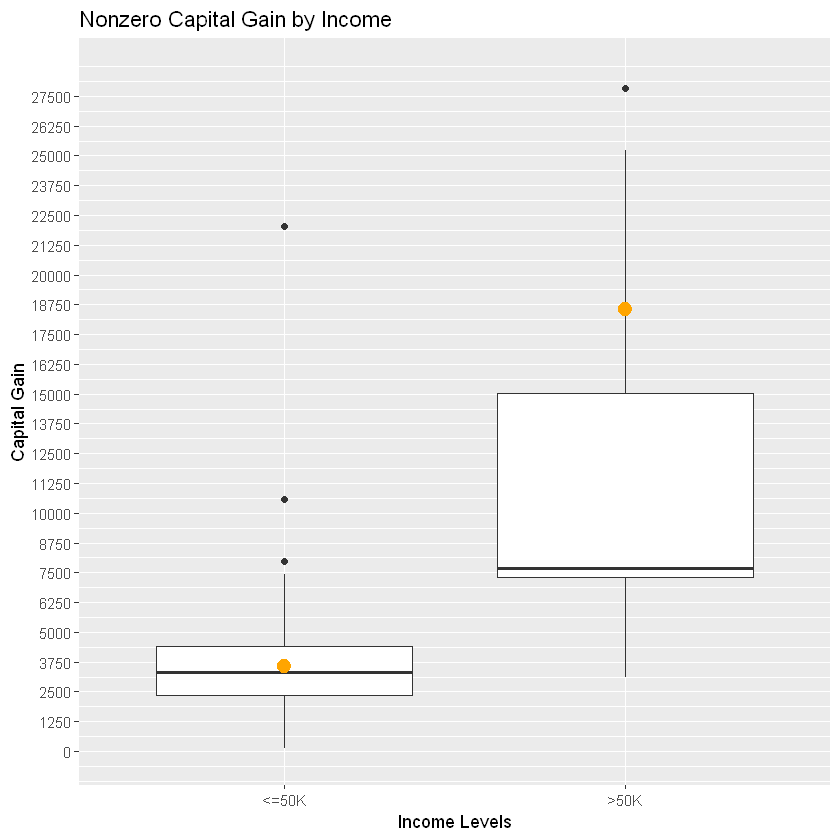

In [27]:
ggplot(mapping = aes(x = income, y = capital_gain),
       data = subset(income_dat, income_dat$capital_gain > 0)) + 
  geom_boxplot() +
  stat_summary(fun.y = mean,geom = 'point',shape = 19,color = "orange",cex = 3.5) +
  coord_cartesian(ylim = c(0, 28500)) +
  scale_y_continuous(breaks = seq(0, 28500, 1250)) +
  labs(x = "Income Levels", y = "Capital Gain") +
  ggtitle("Nonzero Capital Gain by Income") 

We also analyze the new factor variables "cap_gain" and "cap_loss" as Capital Gain/Loss are highly correlated to our independent variable "income". We now see that zero percentage of the people who earn less than 50K per year have a high capital gain

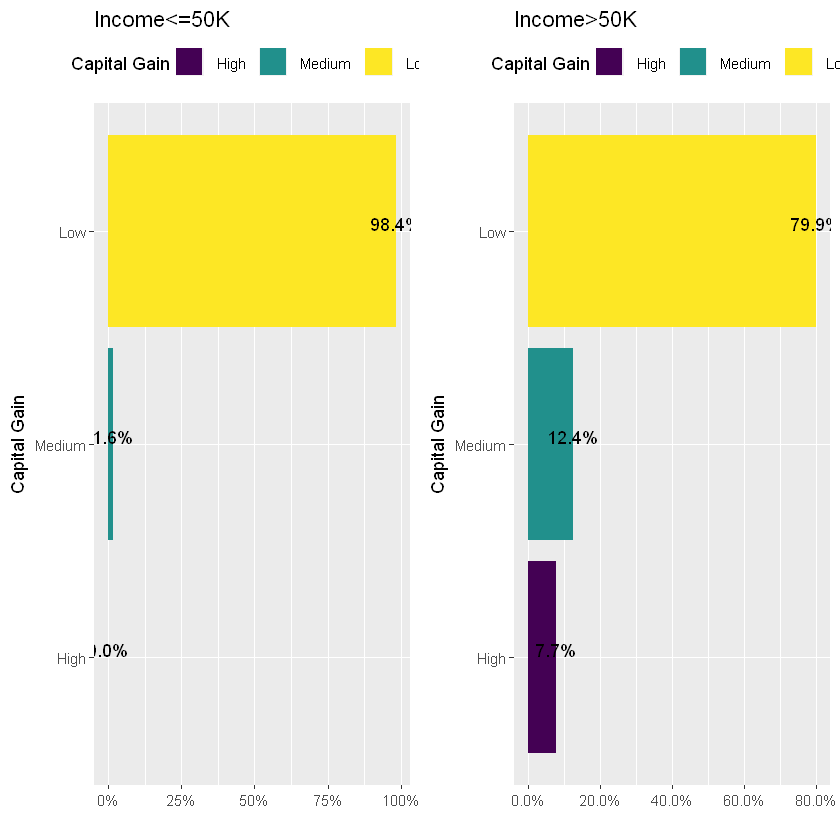

In [28]:
# Bar plot

gain_lg <- lapply(X = levels(income_dat$income), FUN = function(v){  
  df <- subset(income_dat, income_dat$income == v)     
  df <- within(df, cap_gain <- factor(cap_gain, levels = names(sort(table(cap_gain), 
                                                          decreasing = FALSE))))
    
  ggplot(data = df, aes(x = cap_gain, fill = cap_gain)) + 
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    coord_flip() + 
    theme(legend.position = "top") +
    geom_text(aes(label = scales::percent((..count..)/sum(..count..)),
                y = (..count..)/sum(..count..) ), stat = "count", vjust = -.1) +
    labs(x = "Capital Gain", y = "", fill = "Capital Gain") +
    ggtitle(paste("Income", v, sep = "")) +  
    scale_y_continuous(labels = percent) })

grid.arrange(grobs = gain_lg, ncol = 2)

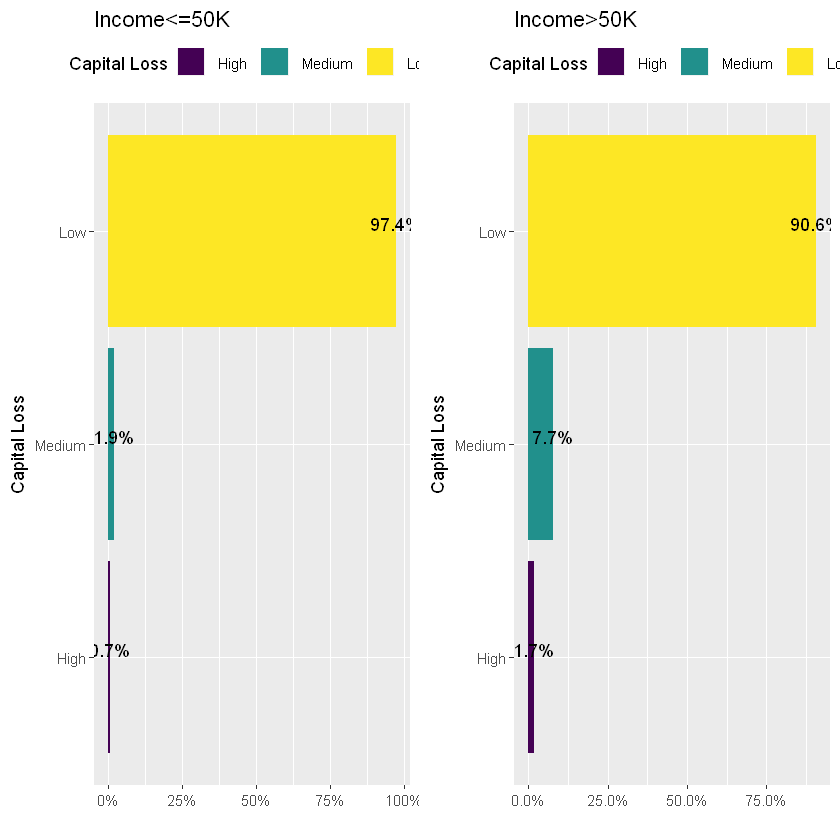

In [29]:
# Bar plot of cap_loss (by income)

loss_lg <- lapply(X = levels(income_dat$income), FUN = function(v){  
  df <- subset(income_dat, income_dat$income == v)     
  df <- within(df, cap_loss <- factor(cap_loss, levels = names(sort(table(cap_loss), 
                                                          decreasing = FALSE))))
    
  ggplot(data = df, aes(x = cap_loss, fill = cap_loss)) + 
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    coord_flip() + 
    theme(legend.position = "top") +
    geom_text(aes(label = scales::percent((..count..)/sum(..count..)),
                y = (..count..)/sum(..count..) ), stat = "count", vjust = -.1) +
    labs(x = "Capital Loss", y = "", fill = "Capital Loss") +
    ggtitle(paste("Income", v, sep = "")) +  
    scale_y_continuous(labels = percent) })

grid.arrange(grobs = loss_lg, ncol = 2)

We now take a look on variable "age" and find its mean value and median value

In [30]:
summary(income_dat$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   28.00   37.00   38.44   47.00   90.00 

We can see the bulk of individuals are from 20 to 50

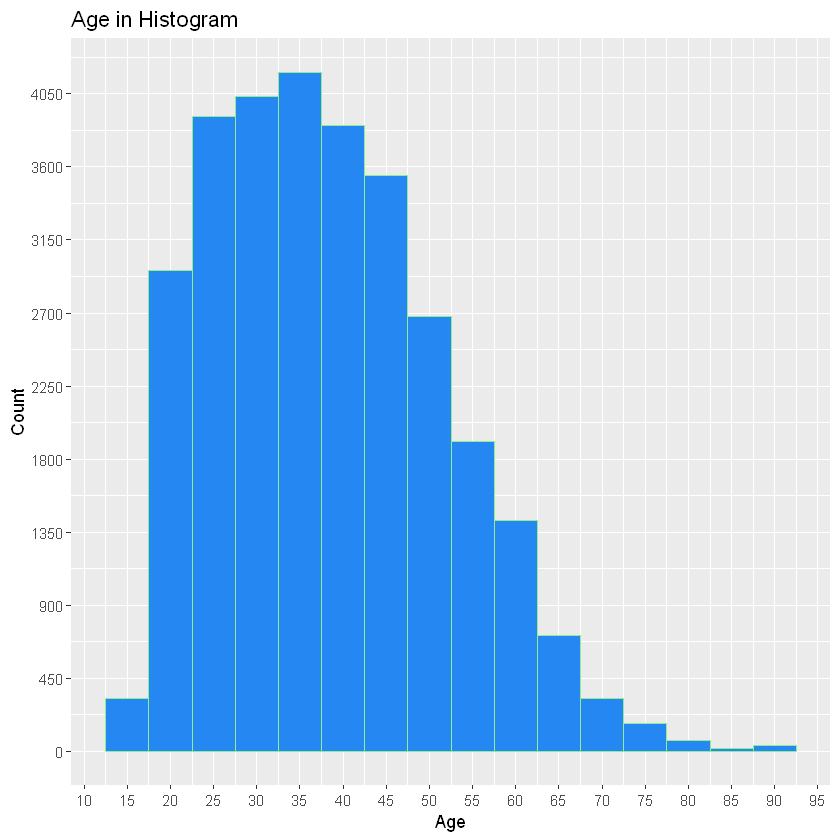

In [31]:
# We can see the bulk of individuals are from 20 to 50
qplot(x = income_dat$age, data = income_dat, binwidth = 5, 
      color = I('lightgreen'), fill = I('#2587f2'), xlab = "Age", ylab = "Count",
      main = "Age in Histogram") +
  scale_x_continuous(breaks = seq(0, 100, 5)) +   
  scale_y_continuous(breaks = seq(0, 5000, 450))

Grouped by income, we now can see the majority of people earning more than 50K per year are between approximate 35 and 55

Warning message:
"`position` is deprecated"

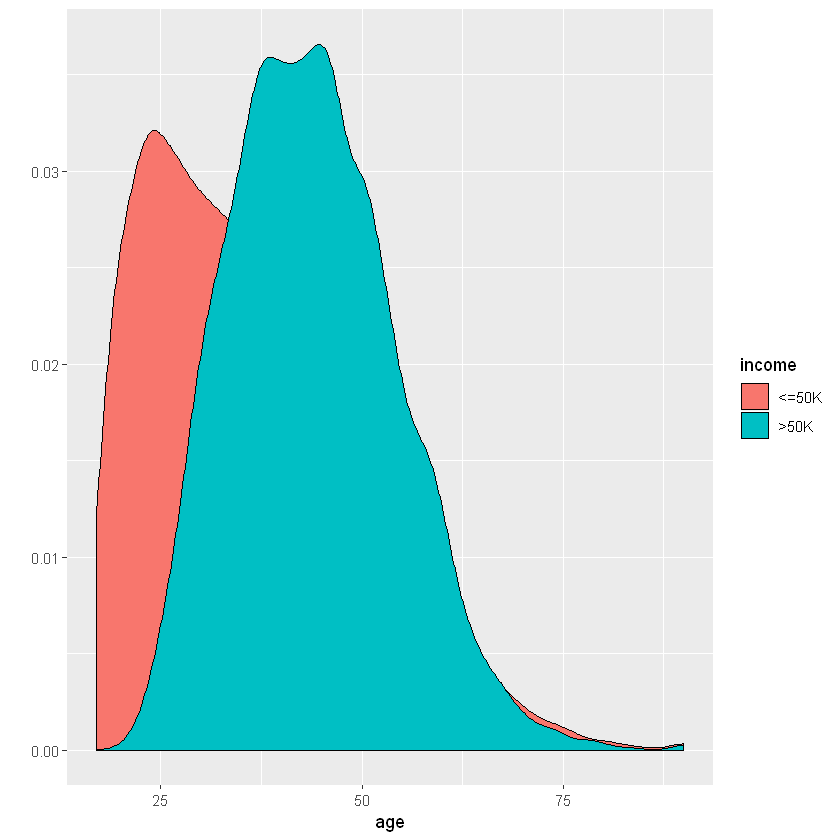

In [32]:
# empirical density chart
with(income_dat, qplot(age, fill=income, geom="density", position="fill")) 

People of greater age have higher income

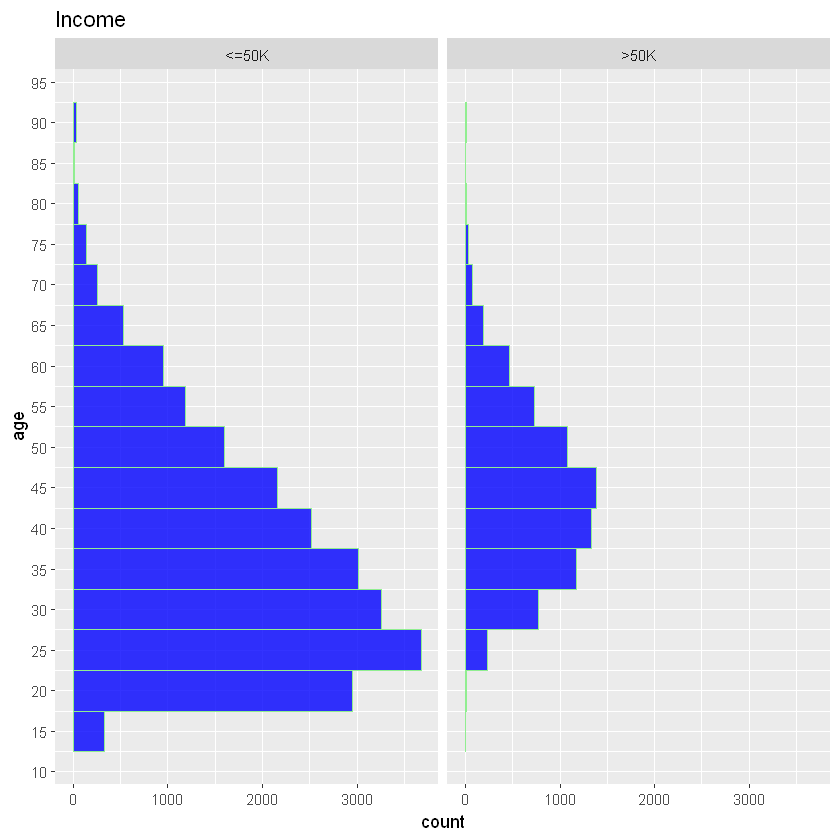

In [33]:
ggplot(data = income_dat, mapping = aes(x = age)) + 
  geom_histogram(binwidth = 5, color = "lightgreen", fill = "blue", alpha = 0.8) +
  coord_flip() + 
  theme(legend.position = "top") +
  scale_x_continuous(breaks = seq(0, 100, 5)) + 
  facet_wrap(~income) +
  ggtitle("Income") 

In [34]:
summary(subset(income_dat$age, income_dat$income == "<=50K"))
summary(subset(income_dat$age, income_dat$income == ">50K"))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   26.00   34.00   36.61   45.00   90.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.00   36.00   43.00   43.96   51.00   90.00 

From the plot below, we can see the probability of having an income greater than 50K is about 60% (the biggest) for individuals in their 50s

Warning message:
"In density.default(x, bw = bw, n = n, ...) :
 extra argument 'colours' will be disregarded"Warning message:
"In density.default(x[y %in% levels(y)[seq_len(i)]], bw = dx$bw, 
    n = n, from = min(dx$x), to = max(dx$x), ...) :
 extra argument 'colours' will be disregarded"

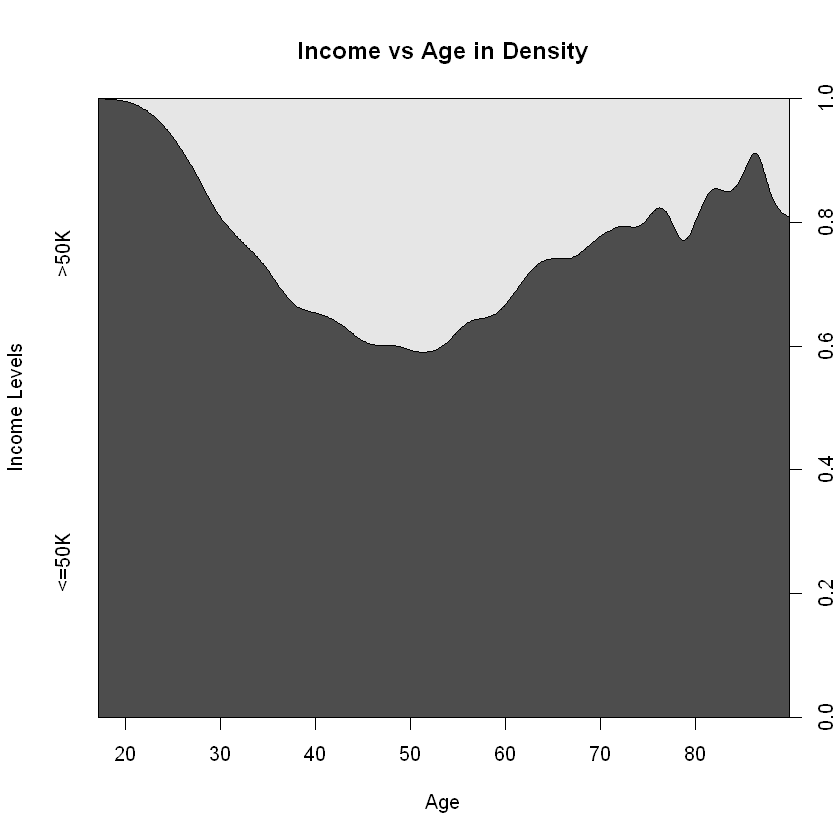

In [35]:
cdplot(income_dat$income ~ income_dat$age, bw = 1.5,
        xlab = "Age",
        ylab = "Income Levels",
        colours = "darkblue",
        main = "Income vs Age in Density")

Per foregoing discussing, we know "hours_per_week" is highly correlated to our target independent variable "income". Let's check its mean value and visualize it grouping by income level

In [36]:
summary(income_dat$hours_per_week)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   40.00   40.00   40.93   45.00   99.00 

Now let's separate the income levels into groups and check their mean values

In [37]:
summary(subset(income_dat$hours_per_week, income_dat$income == "<=50K"))
summary(subset(income_dat$hours_per_week, income_dat$income == ">50K"))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   38.00   40.00   39.35   40.00   99.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   40.00   40.00   45.71   50.00   99.00 

Let's now take a look into the derived variable "dif_hours" and see if there is a match with "hours_per_week"

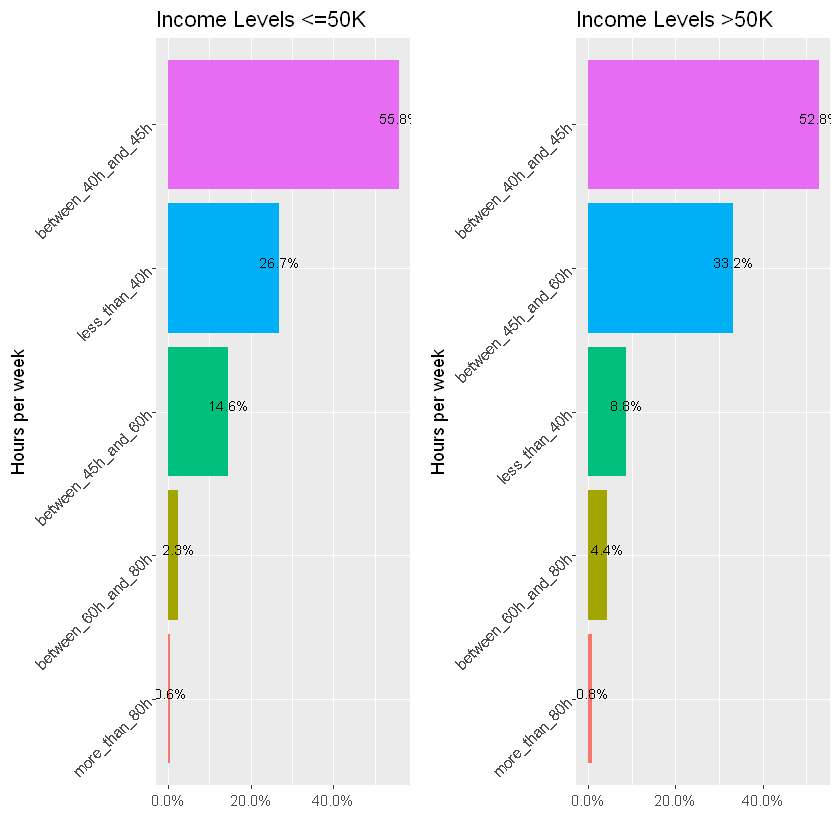

In [38]:
hpw_lg <- lapply(levels(income_dat$income), function(v){    
    df <- subset(income_dat, income_dat$income == v)     
    df <- within(df, dif_hours <- factor(dif_hours, levels = names(sort(table(dif_hours), 
                                                           decreasing = FALSE))))
  
    ggplot(data = df, aes(x = dif_hours, fill = dif_hours)) + 
      geom_bar(aes(y = (..count..)/sum(..count..))) +
      coord_flip() + 
      theme(legend.position = "top") +

      geom_text(aes(label = scales::percent((..count..)/sum(..count..)),
                    y = (..count..)/sum(..count..) ), stat = "count", vjust = -.1, size = 3) +
      labs(x = "Hours per week", y = "", fill = "Hours per week") +
    theme(legend.position = "", axis.text.y = element_text(angle = 45, hjust = 1)) +
      ggtitle(paste("Income Levels ", v, sep="")) + 
      scale_y_continuous(labels = percent) })

grid.arrange(grobs = hpw_lg, ncol = 2)

Education factor is highly correlated to "income". Let's repeat the foregoing pre-process on this factor

In [39]:
cor(income_dat$education_num, income_dat$incomeN2, method = "pearson")

[1] 0.3352862

In [40]:
summary(income_dat$education)

10th         11th         12th      1st-4th      5th-6th      7th-8th 
         820         1048          377          151          288          557 
         9th   Assoc-acdm    Assoc-voc    Bachelors    Doctorate      HS-grad 
         455         1008         1307         5044          375         9840 
     Masters    Preschool  Prof-school Some-college 
        1627           45          542         6678

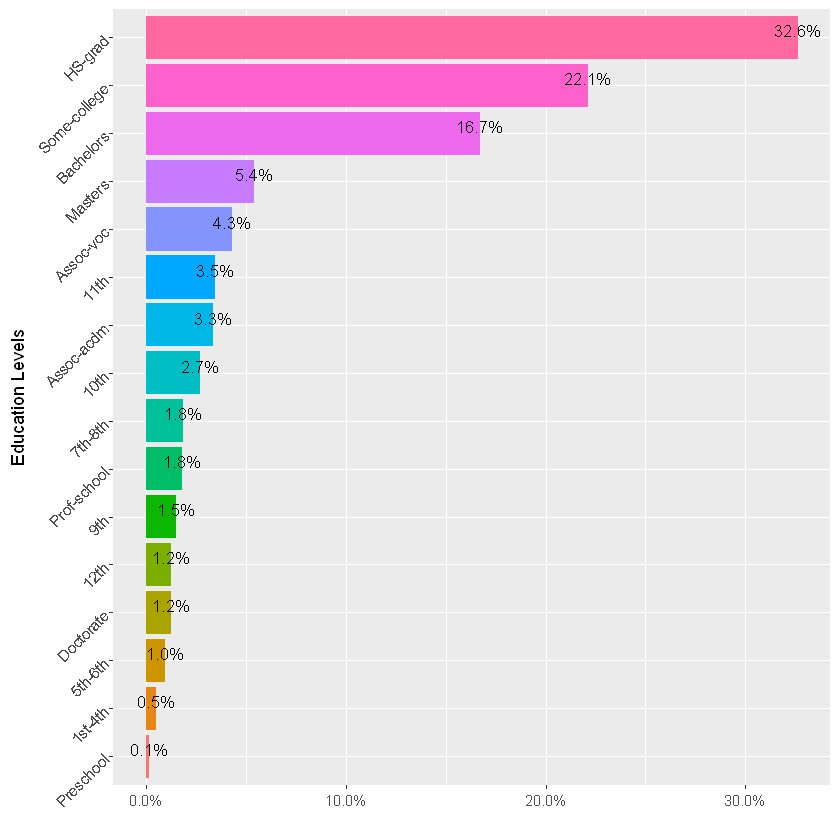

In [41]:
income_dat$education <- factor(income_dat$education, levels = names(sort(table(income_dat$education),   
                                                                               decreasing = FALSE)))

ggplot(income_dat, aes(x = income_dat$education, fill = income_dat$education)) + 
  geom_bar(aes(y = (..count..)/sum(..count..))) +
  coord_flip() + 
  theme(legend.position = "top") +
  geom_text(aes(label = scales::percent((..count..)/sum(..count..)), y = (..count..)/sum(..count..) ), 
            stat = "count", vjust = -.1, size = 3.5) +
  labs(x = "Education Levels", y = "", fill = "Education Levels") +
  theme(legend.position = "", axis.text.y = element_text(angle = 45, hjust = 1)) +
  scale_y_continuous(labels = percent)

Check if there is exception for which anyone earns greater than 50K but his/her educaiton level is only "Preschool"?

In [42]:
nrow(subset(income_dat, income_dat$education == "Preschool" &
                        income_dat$income == ">50K" ))

[1] 0

So, now we drop this level ("Preschool")

In [43]:
new_edu <- levels(income_dat$education)
new_edu <- new_edu[!is.element(new_edu, "Preschool")]

We should be able to provide more supportive evidences using the following plot - 

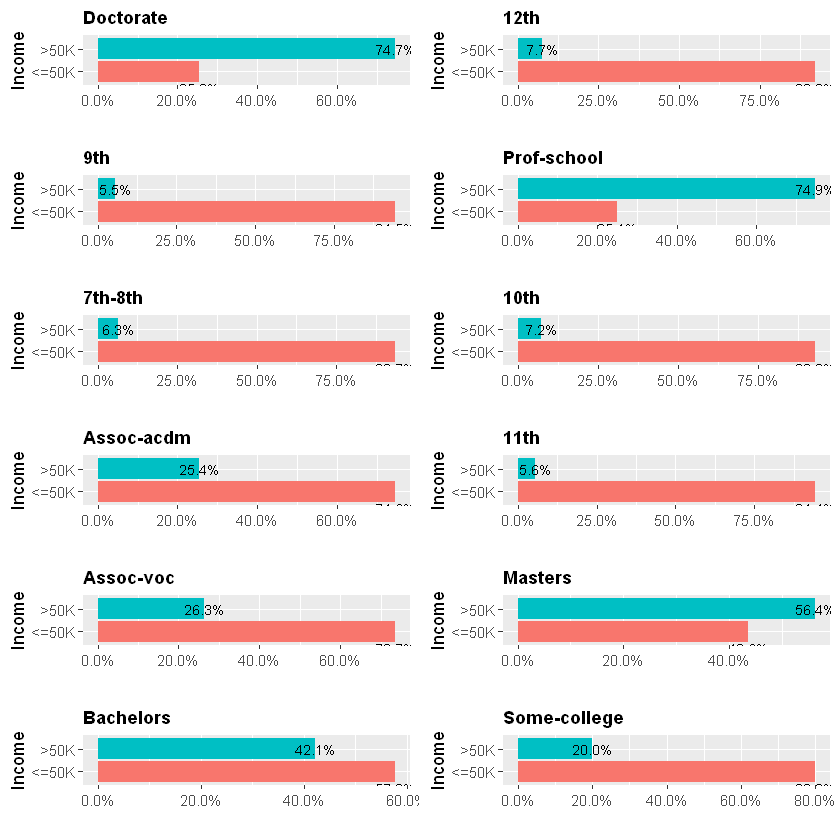

In [44]:
edu_mod_lg <- lapply(new_edu, function(v){
  ggplot(data = subset(income_dat, income_dat$education == v), aes(x = subset(income_dat, income_dat$education == v)$income, 
             fill = subset(income_dat, income_dat$education == v)$income)) +
    geom_bar(aes(y = (..count..)/sum(..count..))) +
    coord_flip() + 
    theme(legend.position = "top") +
    geom_text(aes(label = scales::percent((..count..)/sum(..count..)), y = (..count..)/sum(..count..)), 
             stat = "count", vjust =  c(2, 0.5), size = 3) +
    labs(x = "Income", y = "", fill = "Income") +
    ggtitle(v) +  
    theme(legend.position = "", plot.title = element_text(size = 11, face = "bold")) +    
    scale_y_continuous(labels = percent) })

grid.arrange(grobs = edu_mod_lg[3:14], ncol = 2)

Now let's work on variable "sex" and repeat the foregoing pre-process to explore the insight information

The following bar plots using percentages are easier to interpret rather than row counts

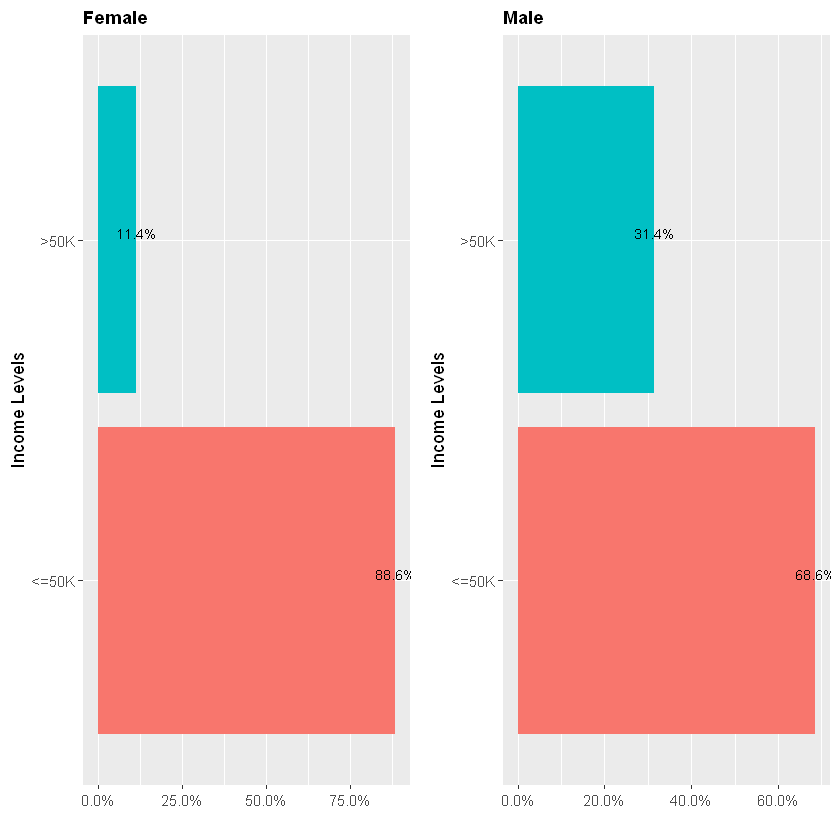

In [46]:
gender_income <- lapply(levels(income_dat$sex), function(v){
   ggplot(data = subset(income_dat, income_dat$sex == v), aes(x = subset(income_dat, income_dat$sex == v)$income, 
             fill = subset(income_dat, income_dat$sex == v)$income))+
  geom_bar(aes(y = (..count..)/sum(..count..))) +
  coord_flip() + 
  theme(legend.position = "top") +
  geom_text(aes(label = scales::percent((..count..)/sum(..count..)), y = (..count..)/sum(..count..)), 
            stat = "count", vjust = -0.1, size = 3) +
  labs(x = "Income Levels", y = "", fill = "Income levels") +
  ggtitle(paste(v)) +  
  theme(legend.position = "", plot.title = element_text(size = 11, face = "bold"),
        axis.text.y = element_text(hjust = 1)) +     
  scale_y_continuous(labels = percent) })

grid.arrange(grobs = gender_income, ncol = 2)

The following numbers match what we see from the bar charts above

In [47]:
# Proportion of men and women with income <50K and >=50K:
prop.table(table(income_dat$sex, income_dat$income), margin = 1)

        
             <=50K      >50K
  Female 0.8863218 0.1136782
  Male   0.6861629 0.3138371

The following bar charts show that the percentages of women and men belonging to each education level are very similar

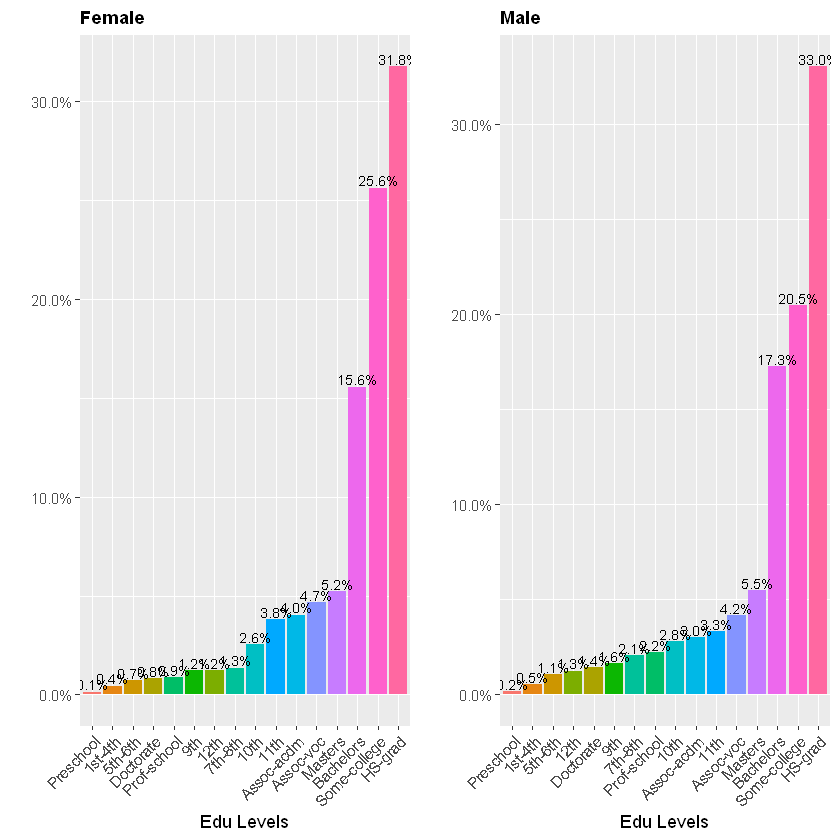

In [48]:
lg_gender_edu <- lapply(levels(income_dat$sex), function(v){    
    df <- subset(income_dat, income_dat$sex == v)      
    df <- within(df, education <- factor(education, levels = names(sort(table(education), 
                                                                   decreasing = FALSE))))
       
   ggplot(data = df, aes(x = df$education, fill = subset(income_dat, income_dat$sex == v)$education))+
     geom_bar(aes(y = (..count..)/sum(..count..))) +
     geom_text(aes(label = scales::percent((..count..)/sum(..count..)), y = (..count..)/sum(..count..)), 
               stat = "count", vjust = -0.2, size = 3) +
     labs(x = "Edu Levels", y = "", fill = "Edu Levels") +
     ggtitle(paste(v)) +  
     theme(legend.position = "", plot.title = element_text(size = 11, face = "bold"),
           axis.text.x = element_text(angle = 45, hjust = 1)) +     
     scale_y_continuous(labels = percent) })

grid.arrange(grobs = lg_gender_edu, ncol = 2)

## Feature Engineering

Since the columns of which the descriptive values don't effect our prediction, we can drop them

In [49]:
drops <- c("workclass","education","occupation","relationship","race","native_country","incomeN1","incomeN2")
income_dat <- income_dat[, !(names(income_dat) %in% drops)]
income_dat[0:3,]

age,fnlwgt,education_num,marital_status,sex,capital_gain,capital_loss,hours_per_week,income,dif_hours,native_region,cap_gain,cap_loss
82,132870,9,Widowed,Female,0,4356,18,<=50K,less_than_40h,United-States,Low,High
54,140359,4,Divorced,Female,0,3900,40,<=50K,between_40h_and_45h,United-States,Low,High
41,264663,10,Separated,Female,0,3900,40,<=50K,between_40h_and_45h,United-States,Low,High


Convert the categorical values (income)¶

In [50]:
#ifelse(income_dat$income == "somevalue",0,1)
levels(income_dat$income) <- c(0,1)
income_dat$income2 <- as.numeric(levels(income_dat$income))[income_dat$income]

In [51]:
income_dat$marital_status <- as.factor(income_dat$marital_status)
income_dat$marital_status2 <- as.numeric(income_dat$marital_status)

income_dat$sex <- as.factor(income_dat$sex)
income_dat$sex2 <- as.numeric(income_dat$sex)

income_dat$dif_hours <- as.factor(income_dat$dif_hours)
income_dat$dif_hours2 <- as.numeric(income_dat$dif_hours)

income_dat$native_region <- as.factor(income_dat$native_region)
income_dat$native_region2 <- as.numeric(income_dat$native_region)

income_dat$cap_gain <- as.factor(income_dat$cap_gain)
income_dat$cap_gain2 <- as.numeric(income_dat$cap_gain)

income_dat$cap_loss <- as.factor(income_dat$cap_loss)
income_dat$cap_loss2 <- as.numeric(income_dat$cap_loss)

In [52]:
income_dat <- income_dat %>% select("age","fnlwgt","education_num","marital_status2","sex2","capital_gain","capital_loss",
                                   "hours_per_week","dif_hours2","native_region2","cap_gain2","cap_loss2","income2")
setnames(income_dat, old = c("marital_status2","sex2","dif_hours2","native_region2","cap_gain2","cap_loss2","income2"),
        new = c("marital_status","sex","dif_hours","native_region","cap_gain","cap_loss","income"))
income_dat[0:3,]

age,fnlwgt,education_num,marital_status,sex,capital_gain,capital_loss,hours_per_week,dif_hours,native_region,cap_gain,cap_loss,income
82,132870,9,7,1,0,4356,18,1,5,1,3,0
54,140359,4,1,1,0,3900,40,2,5,1,3,0
41,264663,10,6,1,0,3900,40,2,5,1,3,0


In [53]:
# Review the new structure
summary(income_dat)

      age            fnlwgt        education_num   marital_status
 Min.   :17.00   Min.   :  13769   Min.   : 1.00   Min.   :1.00  
 1st Qu.:28.00   1st Qu.: 117627   1st Qu.: 9.00   1st Qu.:3.00  
 Median :37.00   Median : 178425   Median :10.00   Median :3.00  
 Mean   :38.44   Mean   : 189794   Mean   :10.12   Mean   :3.58  
 3rd Qu.:47.00   3rd Qu.: 237629   3rd Qu.:13.00   3rd Qu.:5.00  
 Max.   :90.00   Max.   :1484705   Max.   :16.00   Max.   :7.00  
      sex         capital_gain    capital_loss     hours_per_week 
 Min.   :1.000   Min.   :    0   Min.   :   0.00   Min.   : 1.00  
 1st Qu.:1.000   1st Qu.:    0   1st Qu.:   0.00   1st Qu.:40.00  
 Median :2.000   Median :    0   Median :   0.00   Median :40.00  
 Mean   :1.676   Mean   : 1092   Mean   :  88.37   Mean   :40.93  
 3rd Qu.:2.000   3rd Qu.:    0   3rd Qu.:   0.00   3rd Qu.:45.00  
 Max.   :2.000   Max.   :99999   Max.   :4356.00   Max.   :99.00  
   dif_hours     native_region      cap_gain        cap_loss    
 Min

## Split Train & Test Data

In [54]:
dim(income_dat)

[1] 30162    13

In [55]:
# Validation set will be 25% of new income data

set.seed(1)
test_index <- createDataPartition(y = income_dat$income, times = 1, p = 0.25, list = FALSE)
edx <- income_dat[-test_index,]
validation <- income_dat[test_index,]


In [56]:
# print the row numbers of train-set & test-set

trainRows <- dim(edx)[1]
testRows <- dim(validation)[1]
print(trainRows)
print(testRows)

[1] 22621
[1] 7541


## Machine Learning Models / Results

### Decision Tree

In [80]:
library(rpart)

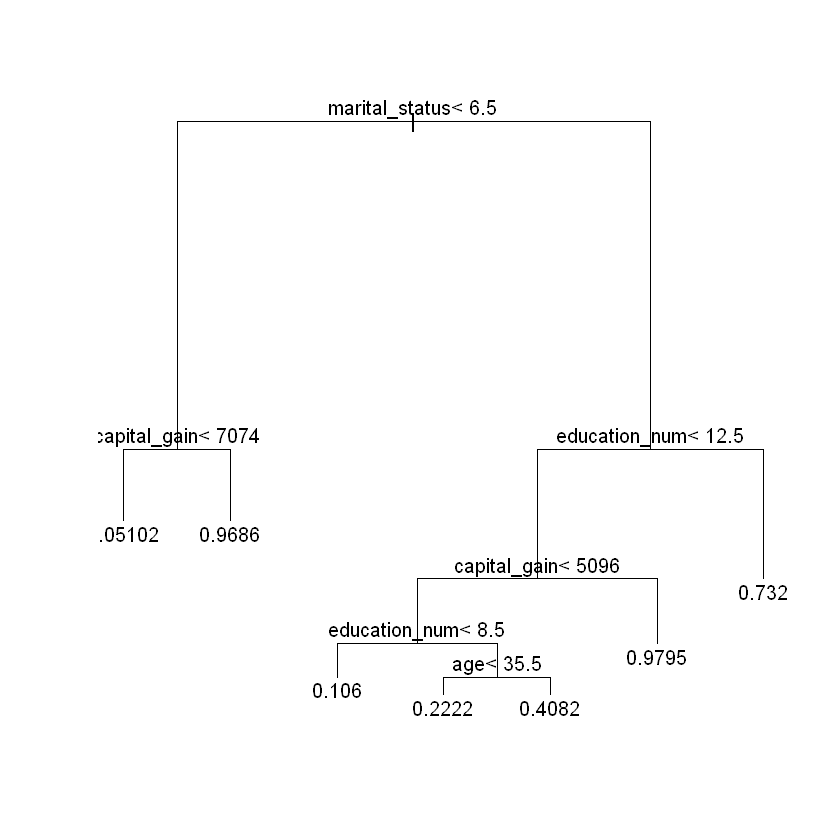

In [81]:
edx_tree <- rpart(income ~ ., 
                  
                     data = edx)
plot(edx_tree)
text(edx_tree)

We plot the decision tree algorithm by using all variables as following - 

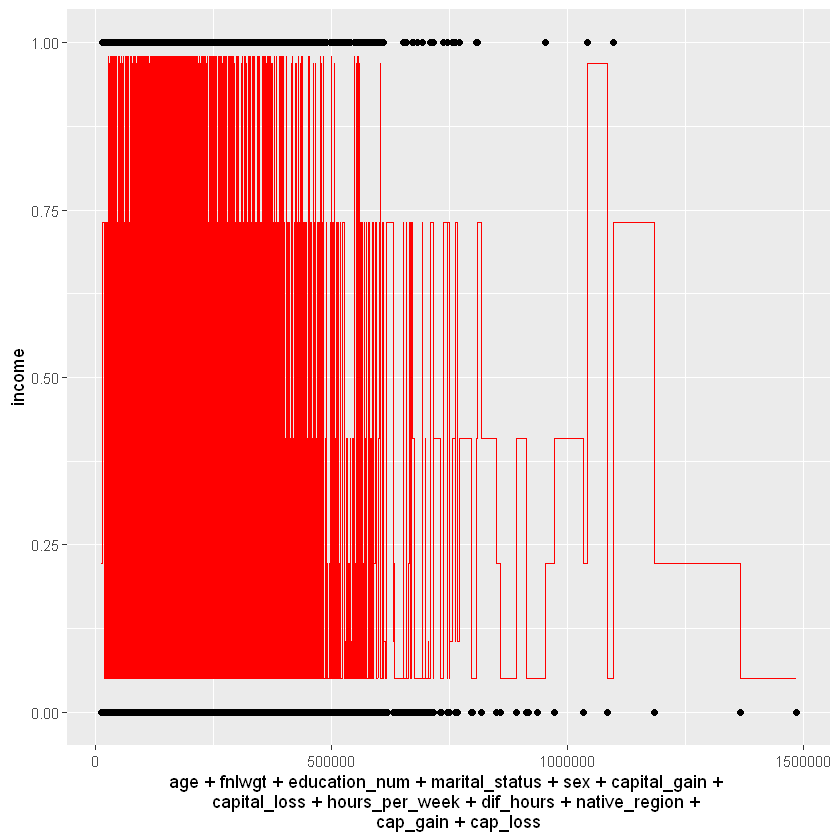

In [82]:

edx %>% 
  mutate(income_hat = predict(edx_tree)) %>% 
  ggplot() +
  geom_point(aes(age+fnlwgt+education_num+marital_status+sex+capital_gain+capital_loss+hours_per_week+dif_hours+native_region+cap_gain+cap_loss, income)) +

  geom_step(aes(age+fnlwgt+education_num+marital_status+sex+capital_gain+capital_loss+hours_per_week+dif_hours+native_region+cap_gain+cap_loss, income_hat), col=2)  

We tune the model via CP value and we find when CP<0.025, we can minimize the RMSE

Warning message in train.default(x, y, weights = w, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."

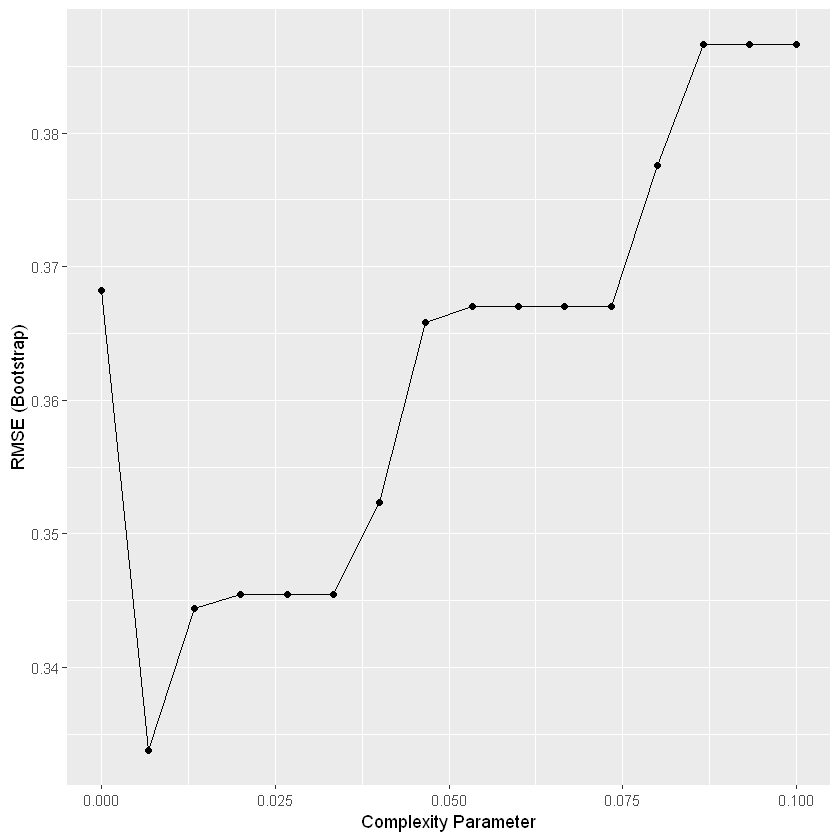

In [85]:

set.seed(1)
fit_rpart <- train(income ~ .,
                  method="rpart",
                  tuneGrid = data.frame(cp=seq(0.0,0.1,len=16)),
                  data = edx)
ggplot(fit_rpart)                

Now we define a function for computing the RMSE

In [87]:
RMSE <- function(true_ratings, predicted_ratings){
  sqrt(mean((true_ratings - predicted_ratings)^2))
}

We now have the RMSE for D-Tree model

In [89]:
d_tree_rmse <- RMSE(validation$income, predict(fit_rpart))
rmse_results <- data_frame(method="D-Tree Model",
                           RMSE = d_tree_rmse)
rmse_results %>% knitr::kable()

Warning message in true_ratings - predicted_ratings:
"longer object length is not a multiple of shorter object length"



|method       |      RMSE|
|:------------|---------:|
|D-Tree Model | 0.5085721|

### Random Forest

In [ ]:
library(randomForest)
library(Rborist)

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"

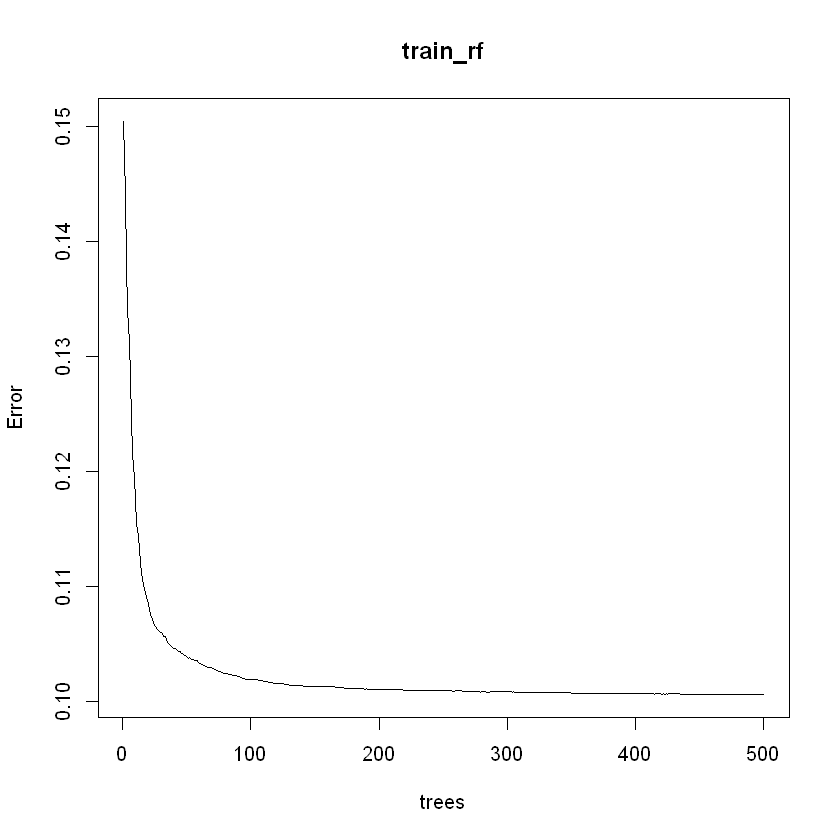

In [93]:
train_rf <- randomForest(income ~ ., data = edx)
plot(train_rf)

From what we see above, we know the more trees does not equal the better. However, the following ggplot should match what we see here

We tune the RF model as following

Warning message in train.default(x, y, weights = w, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."

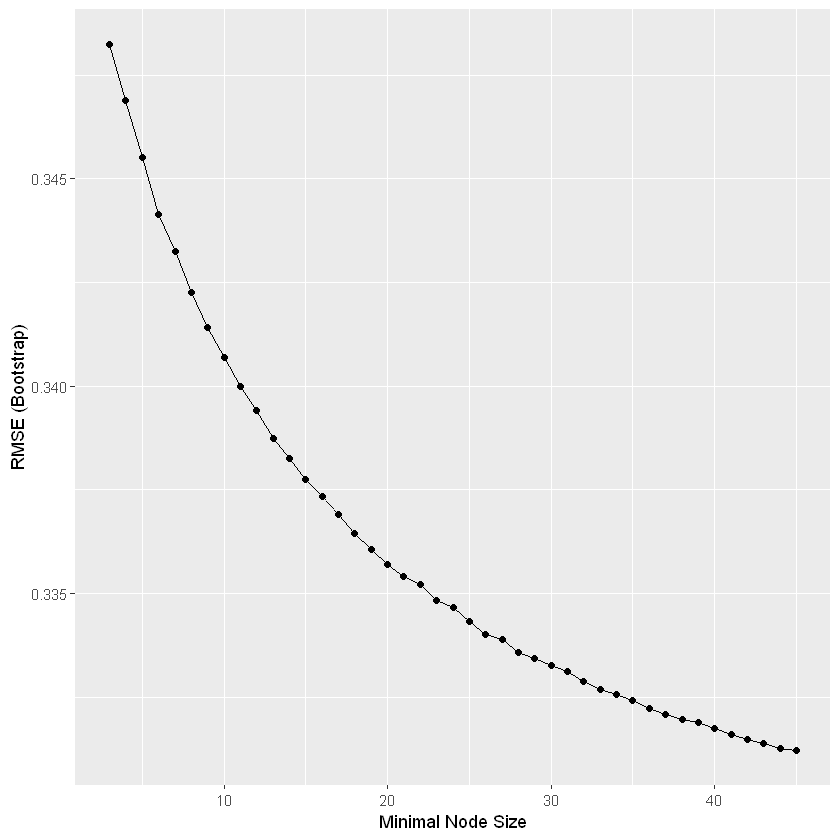

In [97]:
fit_rf <- train(income ~ .,
             method="Rborist",
             tuneGrid=data.frame(predFixed=5,
                                 minNode = seq(3,45)),
             data = edx)  
ggplot(fit_rf)


We now have the RMSE for RF model

In [98]:
rf_rmse <- RMSE(validation$income, predict(fit_rf))
rmse_results <- bind_rows(rmse_results,
                          data_frame(method="Random Forest Model",
                           RMSE = rf_rmse))
rmse_results %>% knitr::kable()

Warning message in true_ratings - predicted_ratings:
"longer object length is not a multiple of shorter object length"



|method              |      RMSE|
|:-------------------|---------:|
|D-Tree Model        | 0.5085721|
|Random Forest Model | 0.5109116|

### Stochastic Gradient Boosting (Generalized Boosted Modeling)

Warning message in train.default(x, y, weights = w, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."

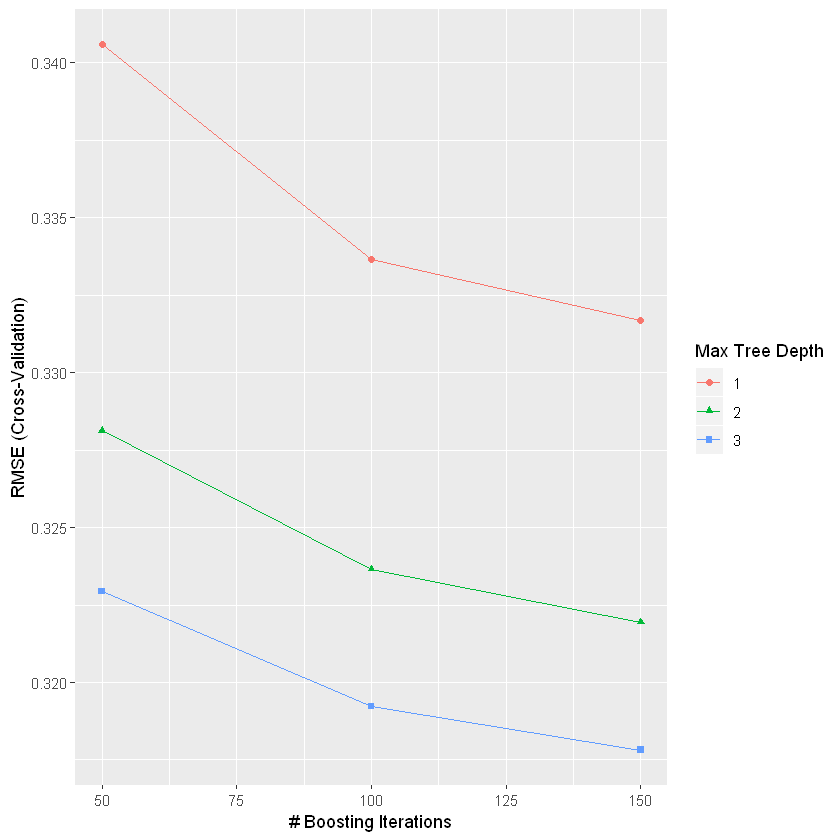

In [102]:
control <- trainControl(method="cv",number=8,p=0.8)

grid <- expand.grid(minNode=c(1,35),predFixed=c(2))

fit_gbm <- train(income ~ .,
                 data = edx,
                 method = "gbm",
                 metric = "RMSE",
                 trControl = control,
                 verbose = FALSE)
                 
ggplot(fit_gbm)

From what we see here, can we say the Generalized Boosted model is better? Let's check the RMSE below

We should now have a comparison for these models

In [103]:
gbm_rmse <- RMSE(validation$income, predict(fit_gbm))
rmse_results <- bind_rows(rmse_results,
                          data_frame(method="Gradient Boosting Model",
                           RMSE = gbm_rmse))
rmse_results %>% knitr::kable()

Warning message in true_ratings - predicted_ratings:
"longer object length is not a multiple of shorter object length"



|method                  |      RMSE|
|:-----------------------|---------:|
|D-Tree Model            | 0.5085721|
|Random Forest Model     | 0.5109116|
|Gradient Boosting Model | 0.5089100|

But what if we use K-NN?

Warning message in train.default(x, y, weights = w, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."

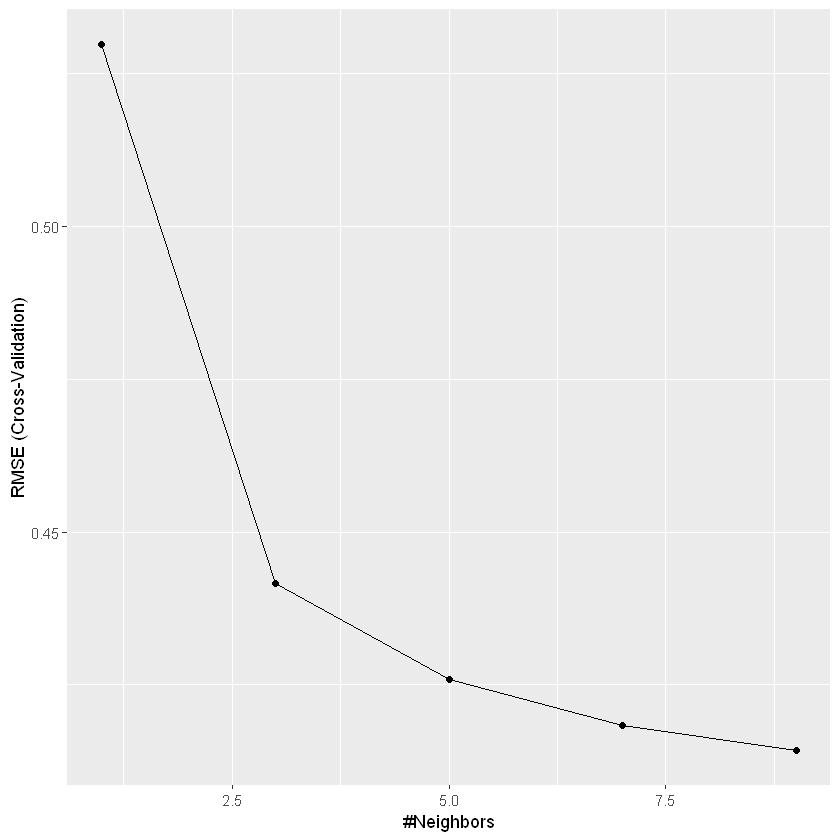

In [104]:
control <- trainControl(method = "cv",number = 9, p=.85)

fit_knn <- train(income ~ .,
                 data=edx,
                 method = "knn",
                 tuneGrid = data.frame(k=c(1,3,5,7,9)),
                 trControl = control)
ggplot(fit_knn)

So from the ggplot above, we can determine the K number by using "elbow method": when K > 2.5

We finally have the comparing RMSE values

In [105]:
knn_rmse <- RMSE(validation$income, predict(fit_knn))
rmse_results <- bind_rows(rmse_results,
                          data_frame(method="K-NN Model",
                           RMSE = knn_rmse))
rmse_results %>% knitr::kable()

Warning message in true_ratings - predicted_ratings:
"longer object length is not a multiple of shorter object length"



|method                  |      RMSE|
|:-----------------------|---------:|
|D-Tree Model            | 0.5085721|
|Random Forest Model     | 0.5109116|
|Gradient Boosting Model | 0.5089100|
|K-NN Model              | 0.4762790|

## Conclusion and Discussion

In this project, we've built several machine learning models to predict if an individual's annual income exceeds $50,000 or not - by using the given set of variables within the dataset. We use root mean squared error (RMSE) to assess performance. As we've seen, D-Tree, Random Forest and Gradient Boosting model have very close RMSE values: approximate 0.51. But K-NN model appear to be the suitable one with approximate 0.48 RMSE value.

Strengths:  By given variables, we built models and evulated them by RMSE. This is able to filter out an algorithm of which it minimizes the RMSE value directly, so that we can use it to predict the independent variable more accurately when compared to other models with higher RMSE values. 

Weaknesses:  The way that we have to try many different algorithms, and therefore it would be very time consuming - because some model like Random Forest, it has a very long runtime - up to hours even a full day. RMSE is an good indicator to assess a model but maybe not enough to determine a good model. Sensitivity, Specificity, Runtime and Accuracy are also very helpful performance indicators when we want to determine a good model. 

So, there are rooms to improve - when we use Causal-Relationship to consider our models. For example, the following way we should be able to expect more from a good model.


In [107]:
# mainly consider the variables with Causal-Relationship
covariates_new <- paste("age","education_num","sex","dif_hours","cap_gain","cap_loss", sep = "+")
form_new <- as.formula(paste("income ~", covariates_new))

start_time <- proc.time()
glm_model <- glm(formula = form_new, data = edx, family = binomial(link = "logit"),
                     x = TRUE,y = TRUE)

In [69]:
car::vif(glm_model)

age education_num           sex native_region     dif_hours 
     1.014430      1.024331      1.038996      1.001020      1.029811 
     cap_gain      cap_loss 
     1.011805      1.003217

In [108]:
predicted_probs <- predict(glm_model, type="response")
glm_rmse <- RMSE(validation$income, predicted_probs)
rmse_results <- bind_rows(rmse_results,data_frame(method="GLM Model",RMSE = glm_rmse))
rmse_results %>% knitr::kable()

Warning message in true_ratings - predicted_ratings:
"longer object length is not a multiple of shorter object length"



|method                  |      RMSE|
|:-----------------------|---------:|
|D-Tree Model            | 0.5085721|
|Random Forest Model     | 0.5109116|
|Gradient Boosting Model | 0.5089100|
|K-NN Model              | 0.4762790|
|GLM Model               | 0.4846054|

In [114]:
observed_values <- ifelse(edx$income  == " >50K", 1, 0)
predicted_response <- ifelse(predicted_probs > 0.5, 1, 0)

mean(observed_values == predicted_response)

[1] 0.8473984

In [115]:
summary(glm_model)


Call:
glm(formula = form_new, family = binomial(link = "logit"), data = edx, 
    x = TRUE, y = TRUE)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4421  -0.6324  -0.4134  -0.0700   3.0815  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -11.868033   0.253815 -46.759  < 2e-16 ***
age             0.042345   0.001472  28.759  < 2e-16 ***
education_num   0.346454   0.008231  42.093  < 2e-16 ***
sex             1.355216   0.047245  28.685  < 2e-16 ***
native_region   0.046517   0.028320   1.643      0.1    
dif_hours      -0.146611   0.018972  -7.728 1.09e-14 ***
cap_gain        2.297994   0.075570  30.409  < 2e-16 ***
cap_loss        0.874054   0.060504  14.446  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 25432  on 22620  degrees of freedom
Residual deviance: 18596  on 22613  degrees of freedom
AIC: 18612

Number 

In [117]:
## Accuracy:
mean(predicted_response == edx$income)

[1] 0.8141108

#### Thank you!